In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from imutils import paths
import seaborn as sns
import random
import time
from datetime import datetime

In [2]:
import cv2
from sklearn.externals import joblib
from skimage.feature import hog
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing th

In [3]:
import os
from skillsnetwork import cvstudio

In [4]:
def load_images(image_paths):
# loop over the input images
    for (i, image_path) in enumerate(image_paths):
        #read image
        image = cv2.imread(image_path)
        image = np.array(image).astype('uint8')
        image = cv2.resize(image, (64, 64))
        grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        hog_features, hog_images = hog(grey_image,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))
        #label image using the annotations
        label = class_object.index(annotations["annotations"][image_path[7:]][0]['label'])
        train_images.append(hog_features)
        train_labels.append(label)


In [5]:

cvstudioClient = cvstudio.CVStudio()

cvstudioClient.downloadAll()

100%|██████████| 800/800 [03:37<00:00,  3.68it/s]


In [6]:
annotations = cvstudioClient.get_annotations()

In [7]:
first_five = {k: annotations["annotations"][k] for k in list(annotations["annotations"])[:5]}
first_five

{'94265bc7-ad78-474f-a802-eb035d0c7a8a.jpg': [{'label': 'cat'}],
 '2bdbff06-bd42-48ed-90a0-6f3e3b6f4388.jpg': [{'label': 'dog'}],
 '36a56cb0-a6a9-478b-b3dd-2f59e17c982a.jpg': [{'label': 'dog'}],
 '04da3bf5-9252-46c7-adea-c3430129851b.jpg': [{'label': 'dog'}],
 'bde043e2-5cd9-43bb-afbf-5c2e609e42be.jpg': [{'label': 'cat'}]}

## Histogram of Oriented Gradients (H.O.G.)


H.O.G. generates a histogram for each localized region. We will pick a random image and see how H.O.G. works.


In [8]:
sample_image = 'images/' + random.choice(list(annotations["annotations"].keys()))

To create H.O.G. features, we will first convert the image to a grayscale image.


In [9]:
sample_image = cv2.imread(sample_image)

Resize the image to a smaller size to allow the algorithm to run faster and convert the images to the grayscale to reduce the number of channels. `OpenCV` reads images as `BGR` so we will be using that color channel to convert to grayscale. 

Early developers at `OpenCV` chose `BGR` color format because it was the format that was popular among camera manufacturers and software providers.


In [10]:
sample_image = cv2.resize(sample_image, (64, 64))
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)

Plot the data to look at what it looks like:


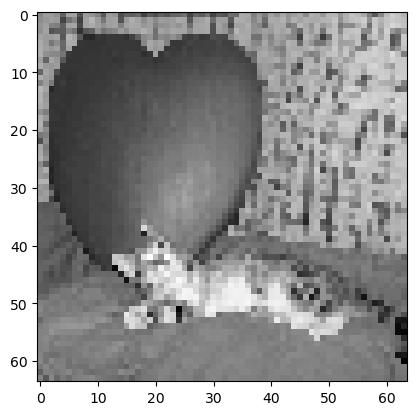

In [11]:
plt.imshow(sample_image, cmap=plt.cm.gray)

Run H.O.G. on the grayscale image to see what it will look like.

H.O.G. stands for Histogram of Oriented Gradients. It uses the gradient orientation of the localized regions of an image and generates a histogram for each localized region.


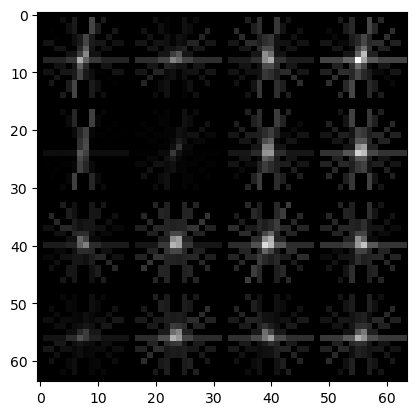

In [12]:

sample_image_features, sample_hog_image = hog(sample_image,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

plt.imshow(sample_hog_image, cmap=plt.cm.gray)

## Load Images and Generate Training/Testing Dataset


Initiate a location for saving loaded images:


In [13]:
image_paths = list(paths.list_images('images'))
train_images = []
train_labels = []
class_object = annotations['labels']

Use the function on the image path:


In [14]:
load_images(image_paths)

Create an array of the images and use the <code>np.vstack</code> to vertically stack arrays for wrangling.


In [15]:
train_array = np.array(train_images)
train_array = np.vstack(train_array)

We will <code>reshape</code> the array to <code>(label size, 1)</code>. The array will look like this: <code>[[1], [0], ..., [0]]</code></p>


In [16]:
labels_array = np.array(train_labels)

In [17]:
labels_array = labels_array.astype(int)
labels_array = labels_array.reshape((labels_array.size,1))

Concatenate the images and labels:


In [18]:
train_df = np.concatenate([train_array, labels_array], axis = 1)

Divide the data into a training and test set:


In [19]:
percentage = 75
partition = int(len(train_df)*percentage/100)

In [20]:
x_train, x_test = train_df[:partition,:-1],  train_df[partition:,:-1]
y_train, y_test = train_df[:partition,-1:].ravel(), train_df[partition:,-1:].ravel()

The  python dictionary <code>param_grid</code>  has different kernels and values of C. We can test them using the validation data.


In [21]:
param_grid = {'kernel': ('linear', 'rbf'),'C': [1, 10, 100]}

In [22]:
base_estimator = SVC(gamma='scale')

In [23]:
start_datetime = datetime.now()
start = time.time()

svm = GridSearchCV(base_estimator, param_grid, cv=5)
#Fit the data into the classifier
svm.fit(x_train,y_train)
#Get values of the grid search
best_parameters = svm.best_params_
print(best_parameters)
#Predict on the validation set
y_pred = svm.predict(x_test)
# Print accuracy score for the model on validation  set. 
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))

end = time.time()
end_datetime = datetime.now()
print(end - start)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/model_selection/_split.py:665: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/model_selection/_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spec

{'C': 100, 'kernel': 'linear'}
Accuracy: 1.0
4.113221645355225


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/model_selection/_search.py:821: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


Get Confusion Matrix for SVM results:


In [24]:
label_names = [0, 1]
cmx = confusion_matrix(y_test, y_pred, labels=label_names)

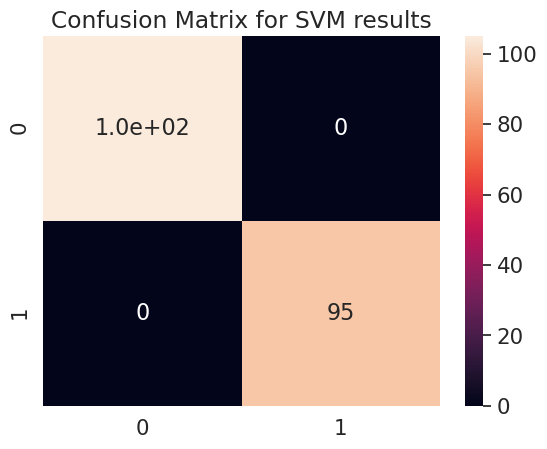

In [25]:
df_cm = pd.DataFrame(cmx)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
title = "Confusion Matrix for SVM results"
plt.title(title)
plt.show()

In [29]:
parameters = {
    'best_params': best_parameters
}
result = cvstudioClient.report(started=start_datetime, completed=end_datetime, parameters=parameters, accuracy=accuracy_score(y_test, y_pred))

if result.ok:
    print('Ok')

Ok


In [27]:

joblib.dump(svm.best_estimator_, 'svm.joblib')

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/externals/joblib/nump

['svm.joblib']

In [28]:

result = cvstudioClient.uploadModel('svm.joblib', {'svm_best': svm.best_estimator_})

File Uploaded
